In [1]:
#import required libraries
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
agora = pd.read_csv(r"Agora.csv",encoding="latin1")
print(agora.shape)
agora.head(5)

(109689, 9)


,Vendor,Category,Item,Item Description,Price,Origin,Destination,Rating,Remarks
0,CheapPayTV,Services/Hacking,12 Month HuluPlus gift Code,12-Month HuluPlus Codes for $25. They are wort...,0.05027025666666667 BTC,Torland,NaN,4.96/5,NaN
1,CheapPayTV,Services/Hacking,Pay TV Sky UK Sky Germany HD TV and much mor...,Hi we offer a World Wide CCcam Service for En...,0.152419585 BTC,Torland,NaN,4.96/5,NaN
2,KryptykOG,Services/Hacking,OFFICIAL Account Creator Extreme 4.2,Tagged Submission Fix Bebo Submission Fix Adju...,0.007000000000000005 BTC,Torland,NaN,4.93/5,NaN
3,cyberzen,Services/Hacking,VPN > TOR > SOCK TUTORIAL,How to setup a VPN > TOR > SOCK super safe enc...,0.019016783532494728 BTC,NaN,NaN,4.89/5,NaN
4,businessdude,Services/Hacking,Facebook hacking guide,. This guide will teach you how to hack Faceb...,0.062018073963963936 BTC,Torland,NaN,4.88/5,NaN


In [3]:
agora.describe()

,Vendor,Category,Item,Item Description,Price,Origin,Destination,Rating,Remarks
count,109689,109689,109687,109662,109684,99807,60528,109674,12616
unique,3192,109,107601,69526,102682,404,1196,478,5
top,optiman,Drugs/Cannabis/Weed,1g MDMA,[----- Terms & Conditions -----] -YOU MUST RE...,1.0 BTC,USA,USA,5.00/5,Average price may be skewed outliar > .5 BTC f...
freq,881,21272,18,264,74,33729,14664,19637,12612


In [4]:
#calculating the percent of NaN in each field
nan_percent = ((len(agora) - agora.count())/agora.count())*100
nan_percent

Vendor                 0.000000
 Category              0.000000
 Item                  0.001823
 Item Description      0.024621
 Price                 0.004559
 Origin                9.901109
 Destination          81.220262
 Rating                0.013677
 Remarks             769.443564
dtype: float64

In [5]:
agora.columns #print the columns 

Index(['Vendor', ' Category', ' Item', ' Item Description', ' Price',
       ' Origin', ' Destination', ' Rating', ' Remarks'],
      dtype='object')

In [6]:
#Strip leading or trailing whitespaces
agora.columns = [x.replace(" ","") for x in agora.columns]
agora.columns

Index(['Vendor', 'Category', 'Item', 'ItemDescription', 'Price', 'Origin',
       'Destination', 'Rating', 'Remarks'],
      dtype='object')

In [7]:
agora["BTC"] = agora["Price"].str.replace('BTC','') #removing BTC text and storing just the bitcoin value
agora.BTC.isnull().sum()

5

In [8]:
agora = agora[pd.notnull(agora["BTC"])]#as only 5 entries have bitcoins as null, we will simply drop them
agora = agora[~agora["BTC"].str.contains(r'[a-zA-Z]{2}|[/]')] #remove any non numeric values in BTC field
agora["BTC"] = pd.to_numeric(agora["BTC"]) #converting data to numeric
agora["USD"] = (agora["BTC"] * 399).round(2) #converting bitcoin value to USD using 399 as conversion factor which was the average price of bitcoin in USD during 2014-15

In [9]:
agora.Destination = agora.Destination.str.upper() #convert the origin and destination country names to upper case
agora.Origin = agora.Origin.str.upper()

In [10]:
#Number of individual vendors
len(agora.Vendor.drop_duplicates())

3189

In [11]:
agora = pd.concat([agora,agora.Category.str.split('/', expand=True)], axis=1)
agora = agora.rename(columns={0: 'cat1', 1: 'cat2',2: 'cat3', 3: 'cat4'}) #dividing the Category field into further sub categories

In [12]:
top_category = agora['cat1'].value_counts(normalize=True)
top_drugs = agora['cat2'].where(agora.cat1=='Drugs').value_counts(normalize=True)
top_weapons = agora['cat2'].where(agora.cat1=='Weapons').value_counts(normalize=True)
top_data = agora['cat2'].where(agora.cat1=='Data').value_counts(normalize=True)
top_service = agora['cat2'].where(agora.cat1=='Services').value_counts(normalize=True)
top_subcategory = agora['cat2'].value_counts(normalize=True)

In [13]:
from nltk import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from wordcloud import WordCloud, STOPWORDS

size = (10,7)
# Function
def cloud(text, title):
    # Processing Text
    stopwords = set(STOPWORDS) # Redundant
    wordcloud = WordCloud(width=800, height=400,
                          
                         ).generate(" ".join(text))
    
    # Output Visualization
    fig = plt.figure(figsize=size, dpi=80, facecolor='k',edgecolor='k')
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=50,color='y')
    plt.tight_layout(pad=0)
    plt.show()

lemm = WordNetLemmatizer()
class LemmaCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))
    
# Define helper function to print top words
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "Topic #{}: ".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
    
def LDA(data, name=""):
    # Storing the entire training text in a list
    text = list(data.values)
    # Calling our overwritten Count vectorizer
    tf_vectorizer = LemmaCountVectorizer(max_df=0.95, min_df=2,
                                              stop_words='english',
                                              decode_error='ignore')
    tf = tf_vectorizer.fit_transform(text)


    lda = LatentDirichletAllocation(n_components=8, max_iter=5,
                                    learning_method = 'online',
                                    learning_offset = 50.,
                                    random_state = 0)

    lda.fit(tf)

    n_top_words = 10
    print("\n{} Topics in LDA model: ".format(name))
    tf_feature_names = tf_vectorizer.get_feature_names()
    print_top_words(lda, tf_feature_names, n_top_words)
    
# Output
pd.set_option('max_colwidth', 700)
pd.set_option('max_info_columns', 100)

def topic_view(df, catlevel, x):
    df = df[df["ItemDescription"].notnull()]
    print(LDA(df.ItemDescription[df[catlevel]==x], name=x))
    cloud(df['Item'][df[catlevel]==x].values,"Cloud for {}".format(x))

    return df.loc[df[catlevel]==x,["Item","ItemDescription"]].sample(4)

In [14]:
expensive_vendors_drugs = agora.loc[agora['cat1']=='Drugs'].groupby("Vendor")['USD'].agg([np.mean]).sort_values(by='mean',ascending=False)[0:15]
expensive_vendors_weapons = agora.loc[agora['cat1']=='Weapons'].groupby("Vendor")['USD'].agg([np.mean]).sort_values(by='mean',ascending=False)[0:15]
expensive_vendors_services = agora.loc[agora['cat1']=='Services'].groupby("Vendor")['USD'].agg([np.mean]).sort_values(by='mean',ascending=False)[0:15]
print('Expensive Drug Dealers:\n',expensive_vendors_drugs,'\n')

print('Expensive Weapon Dealers:\n',expensive_vendors_weapons,'\n')

print('Expensive Services Dealer:\n',expensive_vendors_services)

Expensive Drug Dealers:
                               mean
Vendor                            
heroking              2.897367e+06
EdWestwick            2.281247e+06
Houba                 1.023177e+06
HAPPYholland          8.820701e+05
William_Shatner       8.012523e+05
DakotaFred            7.323484e+05
DutchTruthTeller      7.270003e+05
RADICALRX             3.783312e+05
go_fur                3.250700e+05
sunshines             3.115674e+05
AcidTripsandBongRips  2.465437e+05
GreenStreet           2.141708e+05
BossCaliBud           2.086041e+05
TrapHouse             2.056330e+05
JustSmuggledN!        2.025345e+05 

Expensive Weapon Dealers:
                          mean
Vendor                       
echo            110124.000000
subwaygal         3726.890000
frygirlswirl      3608.377500
Vintorez          3483.468571
OzGuns            3474.876000
SavageS           3324.890000
Victor.But        3132.560000
sturmgawehr       2682.823333
knackersbags88    2428.103333
RTBArms           236

optiman          881
sexyhomer        860
mssource         823
profesorhouse    804
RXChemist        729
rc4me            648
fake             608
medibuds         604
Gotmilk          479
Bigdeal100       451
captainkirk      447
TheDigital       435
OnePiece         430
HollandDutch     416
Optumis          407
Name: Vendor, dtype: int64


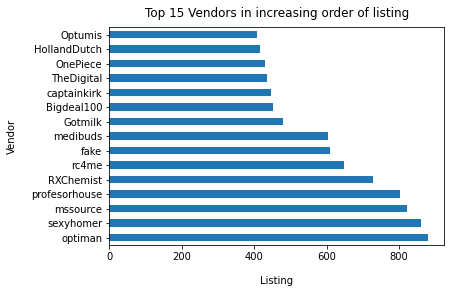

In [15]:
top_15_vendors = agora.Vendor.value_counts()[0:15]
print(top_15_vendors)
#Top 15 Active Vendors
top_15_vendors.plot(kind='barh')
plt.xlabel("Listing",labelpad=14)
plt.ylabel("Vendor",labelpad=14)
plt.title("Top 15 Vendors in increasing order of listing", y=1.02);

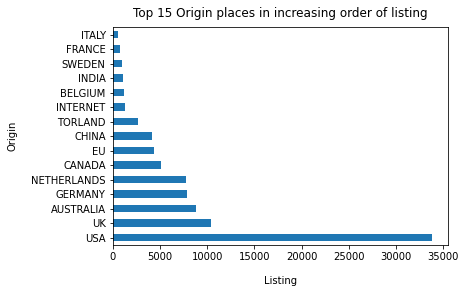

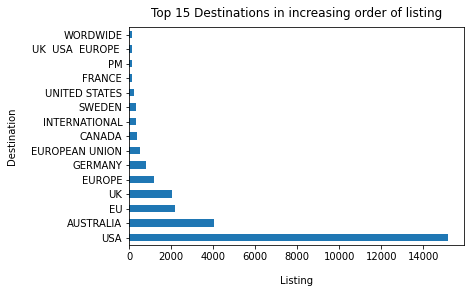

In [16]:
top_15_origin = agora.loc[~agora['Origin'].str.contains(r"(?i)world|(?i)World|(?i)WORLD|(?i)every",na=False),"Origin"].value_counts()[0:15]
top_15_destination = agora.loc[~agora['Destination'].str.contains(r"(?i)world|(?i)World|(?i)WORLD|(?i)every|(?i)ONLY",na=False),"Destination"].value_counts()[0:15]
top_15_origin.plot(kind='barh')
plt.xlabel("Listing",labelpad=14)
plt.ylabel("Origin",labelpad=14)
plt.title("Top 15 Origin places in increasing order of listing", y=1.02);
plt.show()

top_15_destination.plot(kind='barh')
plt.xlabel("Listing",labelpad=14)
plt.ylabel("Destination",labelpad=14)
plt.title("Top 15 Destinations in increasing order of listing", y=1.02);
plt.show()

Drugs                 84.8%
Services               2.4%
Counterfeits           2.2%
Info                   2.0%
Data                   1.9%
Information            1.7%
Other                  1.3%
Forgeries              1.0%
Drug paraphernalia     0.8%
Weapons                0.6%
Electronics            0.5%
Tobacco                0.4%
Jewelry                0.4%
Chemicals              0.1%
Name: cat1, dtype: object


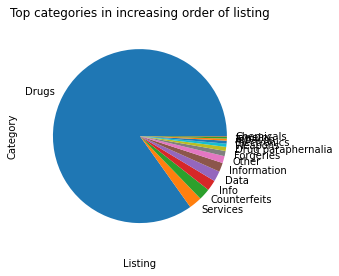

Cannabis         33.5%
Ecstasy          16.1%
Stimulants       13.8%
Psychedelics      9.0%
Opioids           7.4%
Prescription      6.0%
Benzos            5.8%
Steroids          3.0%
RCs               2.3%
Dissociatives     1.9%
Other             0.9%
Weight loss       0.3%
Barbiturates      0.0%
Name: cat2, dtype: object


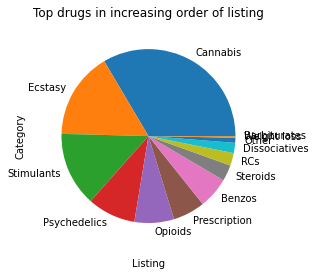

Lethal firearms        52.4%
Ammunition             21.0%
Melee                  15.7%
Non-lethal firearms     8.7%
Fireworks               2.1%
Name: cat2, dtype: object


/run/media/abhijith/D:/VIT_folder/Assignments_in_progress/Data-Analytics-Project/pandas/plotting/_matplotlib/core.py:1547: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


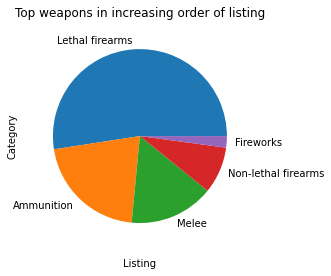

Accounts    58.2%
Pirated     25.0%
Software    16.8%
Name: cat2, dtype: object


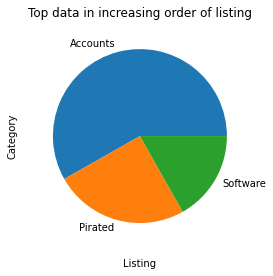

Money          56.0%
Other          18.4%
Hacking        17.1%
Advertising     5.0%
Travel          3.4%
Name: cat2, dtype: object


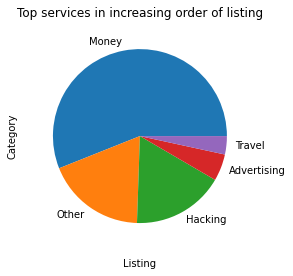

Cannabis               29.1%
Ecstasy                14.0%
Stimulants             12.0%
Psychedelics            7.8%
Opioids                 6.4%
Prescription            5.2%
Benzos                  5.0%
eBooks                  2.9%
Steroids                2.6%
RCs                     2.0%
Money                   1.7%
Dissociatives           1.7%
Other                   1.4%
Watches                 1.2%
Accounts                1.2%
Guides                  0.9%
Physical documents      0.6%
Pirated                 0.5%
Hacking                 0.4%
Smoked                  0.4%
Clothing                0.3%
Software                0.3%
Lethal firearms         0.3%
Scans                   0.3%
Weight loss             0.2%
Accessories             0.2%
Pipes                   0.2%
Containers              0.2%
Stashes                 0.1%
Ammunition              0.1%
Advertising             0.1%
Grinders                0.1%
Melee                   0.1%
Injecting equipment     0.1%
Travel        

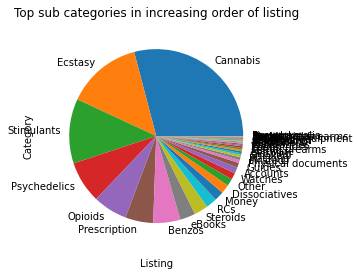

In [17]:
print(top_category.mul(100).round(1).astype(str) + '%')
top_category.plot(kind='pie')
plt.xlabel("Listing",labelpad=14)
plt.ylabel("Category",labelpad=14)
plt.title("Top categories in increasing order of listing", y=1.02);
plt.show()

print(top_drugs.mul(100).round(1).astype(str) + '%')
top_drugs.plot(kind='pie')
plt.xlabel("Listing",labelpad=14)
plt.ylabel("Category",labelpad=14)
plt.title("Top drugs in increasing order of listing", y=1.02);
plt.show()

print(top_weapons.mul(100).round(1).astype(str) + '%')
top_weapons.plot(kind='pie')
plt.xlabel("Listing",labelpad=14)
plt.ylabel("Category",labelpad=14)
plt.title("Top weapons in increasing order of listing", y=1.02);
plt.show()

print(top_data.mul(100).round(1).astype(str) + '%')
top_data.plot(kind='pie')
plt.xlabel("Listing",labelpad=14)
plt.ylabel("Category",labelpad=14)
plt.title("Top data in increasing order of listing", y=1.02);
plt.show()

print(top_service.mul(100).round(1).astype(str) + '%')
top_service.plot(kind='pie')
plt.xlabel("Listing",labelpad=14)
plt.ylabel("Category",labelpad=14)
plt.title("Top services in increasing order of listing", y=1.02);
plt.show()

print(top_subcategory.mul(100).round(1).astype(str) + '%')
top_subcategory.plot(kind='pie')
plt.xlabel("Listing",labelpad=14)
plt.ylabel("Category",labelpad=14)
plt.title("Top sub categories in increasing order of listing", y=1.02);
plt.show()


Drugs Topics in LDA model: 
Topic #0: quality listing fe shipping product best price order high gram
Topic #1: smell white strong taste great like black beautiful potent effect
Topic #2: mg tablet xanax used drug 10mg 10 cut fentanyl alprazolam
Topic #3: pgp ab condition und tracking au ist der version china
Topic #4: pill profile read order listing cocaine vendor ordering page http
Topic #5: strain kush bud indica sativa weed grown grade og high
Topic #6: lsd mdma clean offer tab blotter heroin 50 xtc express
Topic #7: mdma tested pure purity lab speed product delivery 84 meth
None


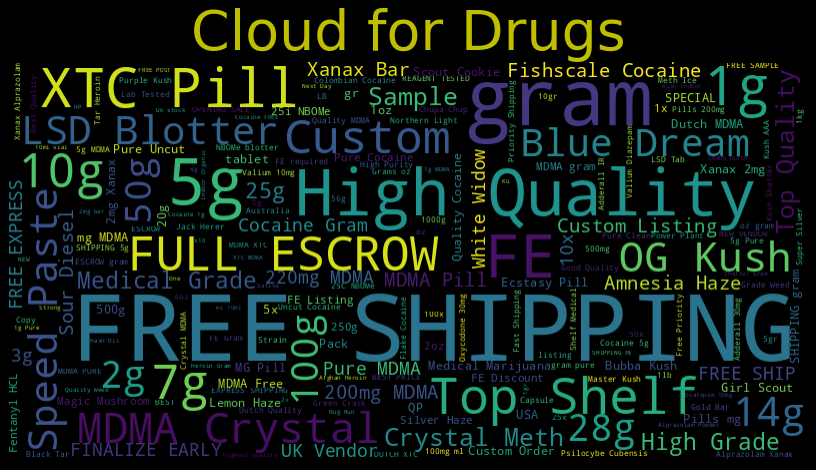

,Item,ItemDescription
24857,1 Gram Afghan #4 Top Quality!!,This is afghan #4. Can be snorted or injected. Very high quality. No cuts added!!
78979,0.5 grams of #4 Heroin - SE Asian Tan Powder,THIS IS A LISTING FOR: 0.5 grams of #4 heroin. This is a tan powder of SE Asian origin. You can snort smoke or inject this product. Please exercise caution as this is more potent than s ...
57549,0.1 gr COCAINE HIGH QUALITY COLOMBIAN COCAINE - EUROPEAN UNION - FREE SHIPPING FAST AND SECURE,Hello Our store is OPEN Get 0.1gr High Quality Colombian Cocaine NO FE
68942,30g AA OG kush FREE SHIPPING,grown with love...small to medium size nugs. nice smell lotsa crystal flushed well taste smooth burns clean.. Please read profile before ordering. I ship this item Xpresspost so depending on w ...


In [18]:
topic_view(df=agora, catlevel="cat1", x="Drugs")


Weapons Topics in LDA model: 
Topic #0: gun 22 round brand time shipping new order bought 100
Topic #1: und lauf zustand mit sehr mehr deutschland natã¼rlich walther incl
Topic #2: listing shipping round glock ammo magazine escrow 100 order item
Topic #3: blade size cm knife ship handle color material length shipping
Topic #4: wie besprochen mentioned baton laser aluminum blue steel expandable victim
Topic #5: gun new glock loud 9mm come shot piece mag small
Topic #6: custom listing ship fe shipped buyer reship good australia pas
Topic #7: http grenade flash knuckle duster lighter com strong escrow xup
None


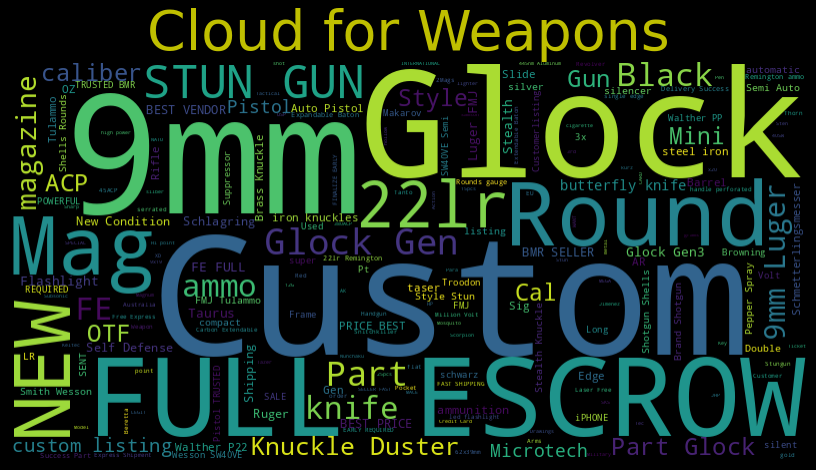

,Item,ItemDescription
25927,Self Defence - Knife: Credit Card Pocket Knife,"Each Credit Card Knife!!! ====================================== Credit Card Style Folding Pocket Knife ====================================== Folds out to a 4"" Blade With Handle! ------------ ..."
94213,taurus pt709 9mm FULL ESCROW,This listing is for the weapon shown. It comes with one magazine and you can order ammo with it 100 rounds for $100 USD. You must also pay for the weapons shipping option on our profile page.
57733,.45 ACP x 50,".45 ACP x 50 Could get you almost everything ammo-based what is not listed here within a short time like ""special Calibers Special Loads Ammunition for old/historic weapons etc. just pm me an ..."
87353,Zip Gun Mini Maglite 22 lr,Selling 22 lr. Zip gun


In [19]:
topic_view(df=agora, catlevel="cat1", x="Weapons")


Services Topics in LDA model: 
Topic #0: 100 order 10 code hour listing online fee voucher com
Topic #1: youtube service view web safely social easily ve custom buy
Topic #2: marketing best pick worldwide better product http spend brand list
Topic #3: card number address cvv phone date city state expiry country
Topic #4: money make method cash amazon bank card transfer btc anonymous
Topic #5: game hd month gold hi device sky offer minecraft following
Topic #6: dollar 00 100 express note 50 aud australian post delivered
Topic #7: account paypal cc service card order listing bank balance buy
None


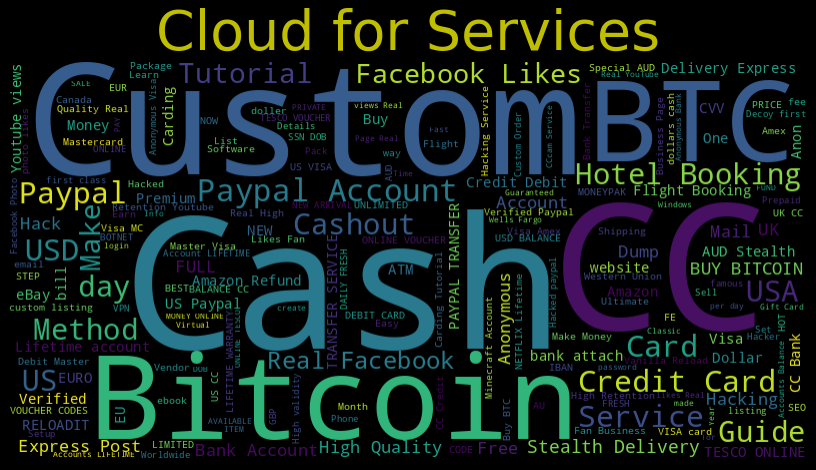

,Item,ItemDescription
31740,Google Voice numbers & accounts,Google voice accounts with their own US phone number
37220,FROM RAGS TO RICHES - A Year of Spicy Sex 52 Recipes to Heat Up Your Sex Life,A Year of Spicy Sex 52 Recipes to Heat Up Your Sex Life Pages:100+ Recipes for sensual skin-centric intercourse-free sexplayâsimply the irresistible delight in one another. Recipes for teasing thr ...
63371,Carding Stuffs with PayPal,Carding Stuffs with PayPal-tutorial
57253,Anonymous Visa USD bank account withdraw your BTC ! NEW CARDS !,PROMOTIONNAL PRICE FOR THE FIRST 10 ORDERS !!! ONLY 25$ EACH !!! [Product description] Polish prepaid Debit card those have IBAN number written on it you can use it as a prepaid bank accou ...


In [20]:
topic_view(df=agora, catlevel="cat1", x="Services")